### What is Similarity Search (in faiss)?

Given a set of vectors, we index them using Faiss and then use another vector \
(query vector) to search for the most similar vectors within the index.

### **Faiss - Facebook AI Similarity Search**

It is one of the most popular implementations of efficient similarity search.

It not only allows us to build an index and search — but it also speeds up \
search times to ludicrous performance levels!

### **Optimizations**

 - IVF indexing
 - Product Quantization

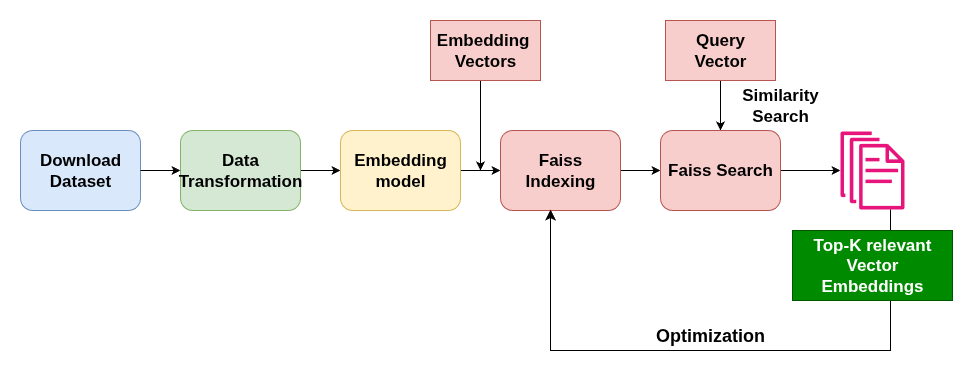

### Installation

In [ ]:
# !pip install faiss-cpu faiss-gpu

### Importing Packages

In [130]:
import requests
from io import StringIO
import pandas as pd

### Downloading Dataset

- Concatenate multiple dataset from semantic test similarity hub repo.
- Extract relevant columns and make a single list.

In [131]:
res = requests.get('https://raw.githubusercontent.com/brmson/dataset-sts/master/data/sts/sick2014/SICK_train.txt')
# create dataframe
data = pd.read_csv(StringIO(res.text), sep='\t')
data.head()

,pair_ID,sentence_A,sentence_B,relatedness_score,entailment_judgment
0,1,A group of kids is playing in a yard and an ol...,A group of boys in a yard is playing and a man...,4.5,NEUTRAL
1,2,A group of children is playing in the house an...,A group of kids is playing in a yard and an ol...,3.2,NEUTRAL
2,3,The young boys are playing outdoors and the ma...,The kids are playing outdoors near a man with ...,4.7,ENTAILMENT
3,5,The kids are playing outdoors near a man with ...,A group of kids is playing in a yard and an ol...,3.4,NEUTRAL
4,9,The young boys are playing outdoors and the ma...,A group of kids is playing in a yard and an ol...,3.7,NEUTRAL


In [132]:
# we take all samples from both sentence A and B
sentences = data['sentence_A'].tolist()
sentence_b = data['sentence_B'].tolist()
sentences.extend(sentence_b)  # merge them
len(set(sentences))  # together we have ~4.5K unique sentences

4802

### Adding more data

In [ ]:
urls = [
    'https://raw.githubusercontent.com/brmson/dataset-sts/master/data/sts/semeval-sts/2012/MSRpar.train.tsv',
    'https://raw.githubusercontent.com/brmson/dataset-sts/master/data/sts/semeval-sts/2012/MSRpar.test.tsv',
    'https://raw.githubusercontent.com/brmson/dataset-sts/master/data/sts/semeval-sts/2012/OnWN.test.tsv',
    'https://raw.githubusercontent.com/brmson/dataset-sts/master/data/sts/semeval-sts/2013/OnWN.test.tsv',
    'https://raw.githubusercontent.com/brmson/dataset-sts/master/data/sts/semeval-sts/2014/OnWN.test.tsv',
    'https://raw.githubusercontent.com/brmson/dataset-sts/master/data/sts/semeval-sts/2014/images.test.tsv',
    'https://raw.githubusercontent.com/brmson/dataset-sts/master/data/sts/semeval-sts/2015/images.test.tsv'
]

In [133]:
# each of these dataset have the same structure, so we loop through each creating our sentences data
for url in urls:
    res = requests.get(url)
    # extract to dataframe
    data_ = pd.read_csv(StringIO(res.text), sep='\t',  header=None, on_bad_lines='skip')
    # add to columns 1 and 2 to sentences list
    sentences.extend(data_[1].tolist())
    sentences.extend(data_[2].tolist())

In [134]:
len(sentences)  # now we have ~8.5K unique sentences

20470

In [135]:
# remove duplicates and NaN
sentences = [word for word in list(set(sentences)) if type(word) is str]

In [136]:
sentences_df = pd.DataFrame({'sentences': sentences})

In [137]:
data = pd.concat([data, sentences_df], axis=1)

In [138]:
data.shape

(14504, 6)

In [139]:
len(sentences)

14504

After removing duplicates, Nan, it gives us 14.5k unique sentences. Next, we build \
dense vectors using sentence-transformers library.

### Building Vectors Embeddings

In [140]:
from sentence_transformers import SentenceTransformer
# initialize sentence transformer model
model = SentenceTransformer('bert-base-nli-mean-tokens')
# create sentence embeddings
sentence_embeddings = model.encode(sentences)
sentence_embeddings.shape

(14504, 768)

### Saving the embeddings 

In [141]:
import numpy as np
np.save('sentence_embeddings.npy', sentence_embeddings)

### Loading the Embeddings

In [142]:
sentence_embeddings = np.load('sentence_embeddings.npy')

### IndexFlatL2

Faiss comes with built-in GPU optimization for Cuda enabled Linux machine.

First, we'll start with plain and simple index with IndexFlatL2.

It measures L2 (Euclidean Distance) distance between all given points between \
our query vector and vectors loaded into the index. It is simple, accurate, and 
**but not fast!**

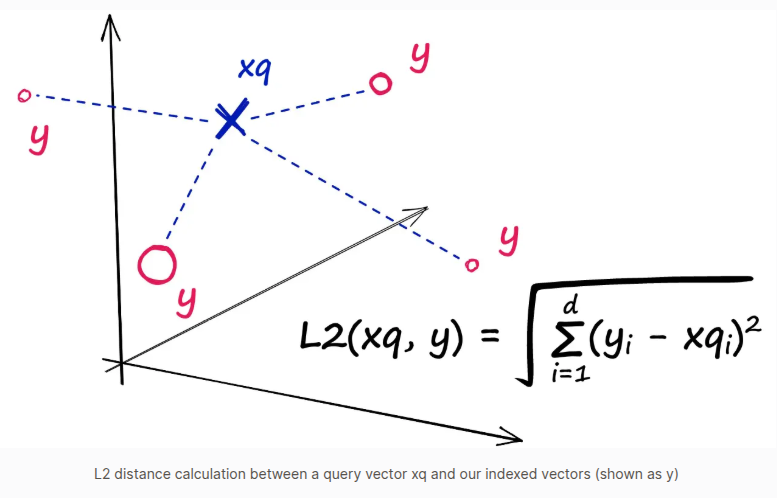

In [143]:
import faiss

In [144]:
d = sentence_embeddings.shape[1]
print(d)

index = faiss.IndexFlatL2(d)
print(index.is_trained)

768
True


In [145]:
index.add(sentence_embeddings)
index.ntotal

14504

In [ ]:
k = 4
xq = model.encode(["Someone sprints with a football"])

In [146]:
%%time
D, I = index.search(xq, k)  # search
print(I)

[[ 330 6201 1305 7055]]
CPU times: user 16.6 ms, sys: 1.33 ms, total: 18 ms
Wall time: 16.3 ms


In [ ]:
#data

In [147]:
data['sentences'].iloc[[330, 6201, 1305, 7055]]

330     A group of football players is running in the ...
6201    A group of people playing football is running ...
1305            Two groups of people are playing football
7055    A person playing football is running past an o...
Name: sentences, dtype: object

Extract numerical vectors from Faiss.

In [148]:
# we have 4 vectors to return (k) - so we initialize a zero array to hold them
vecs = np.zeros((k, d))
# then iterate through each ID from I and add the reconstructed vector to our zero-array
for i, val in enumerate(I[0].tolist()):
    vecs[i, :] = index.reconstruct(val)

In [149]:
print(vecs.shape)
print(vecs[0, :100])  # print first 5 dimensions of first vector

(4, 768)
[ 0.01627072  0.2232592  -0.15037425 -0.30747271 -0.27122465 -0.10593155
 -0.06460934  0.04738171 -0.73349047 -0.37657681 -0.76762789  0.16902882
  0.53107649  0.51176697  1.14415824 -0.08562881 -0.67240071 -0.96637076
  0.02545465 -0.21559809 -1.25656545 -0.82982159 -0.09825006 -0.21850838
  0.50610238  0.10527924  0.50396848  0.6524294  -1.39458752  0.65847486
 -0.21525319 -0.22487473  0.818183    0.08464295 -0.76141769 -0.28928289
 -0.09825794 -0.73046207  0.07855801 -0.84354597 -0.59242105  0.7747131
 -1.20920527 -0.22757922 -1.30733585 -0.23081493 -1.31322539  0.01629098
 -0.97285485  0.19308187  0.47424555  1.18920887 -1.96741295 -0.70061141
 -0.2963869   0.60533738  0.62407422 -0.70340371 -0.86754245  0.17673171
 -0.19170482 -0.02951987  0.22623563 -0.16695446 -0.80402559 -0.45918921
  0.69675452 -0.24928184 -1.01478708 -0.92174506 -0.33842692 -0.39296779
 -0.83734852 -0.11479225  0.4604969  -1.45211208  0.60310405  0.38696292
 -0.04061218  0.00453171  0.24117817  0.053

### Speed

Using the IndexFlatL2 index alone is computationally expensive, it doesn’t scale well.

When using this index, we are performing an exhaustive search — meaning we compare \
our query vector xq to every other vector in our index, in our case that is 14.5K L2-distance \
calculations for every search.


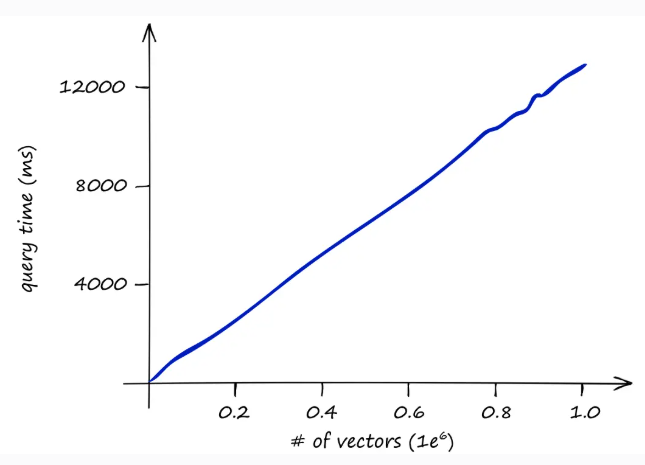

For million or billions of embeddings, the index quickly becomes too slow to be useful, so we need to do something different.

### Partitioning The Index

Faiss allows multiple optimizations of our search using different methods. A popular approach is to partition the index into Voronoi cells.

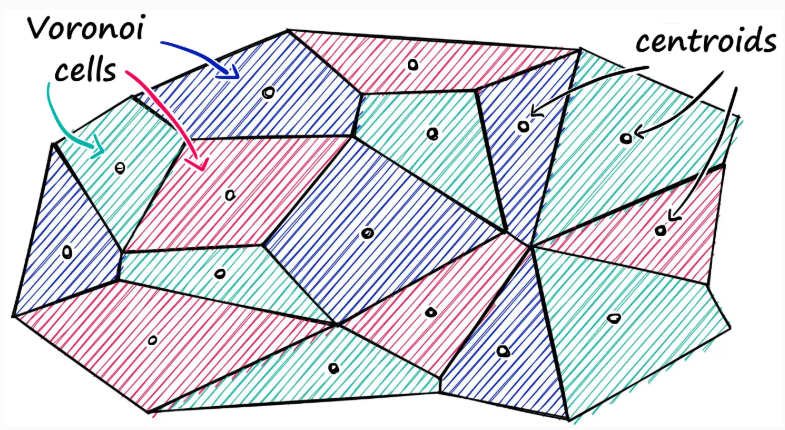

Using this method, query vector xq identify the cell it belongs to, and then uses IndexFlatL2 or (another metric) to\
search between the query vector and all other vector belonging to that specific cell.

We reduce the scope of our search, producing an approximate answer, rather than exact (as produced by exhaustive search).

In [150]:
nlist = 50  # how many cells
quantizer = faiss.IndexFlatL2(d)
index = faiss.IndexIVFFlat(quantizer, d, nlist)

In [151]:
index.is_trained

False

Train the index, such that grouping/transformation are applied on it. Here, we'll add clustering on that index.

In [152]:
index.train(sentence_embeddings)
print(index.is_trained)  # check if index is now trained
index.add(sentence_embeddings)

True


In [153]:
print(index.ntotal)

14504


Again search through query vector and get the top-k.

In [154]:
%%time
D, I = index.search(xq, k)  # search
print(I)

[[ 330 6201 1305 7055]]
CPU times: user 2.02 ms, sys: 0 ns, total: 2.02 ms
Wall time: 1.1 ms


In [155]:
data['sentences'].iloc[[330, 6201, 1305, 7055]]

330     A group of football players is running in the ...
6201    A group of people playing football is running ...
1305            Two groups of people are playing football
7055    A person playing football is running past an o...
Name: sentences, dtype: object

**Note the time taken to search! It drastically reduced from milliseconds to microseconds**

### Scoped Search after partitioning the index

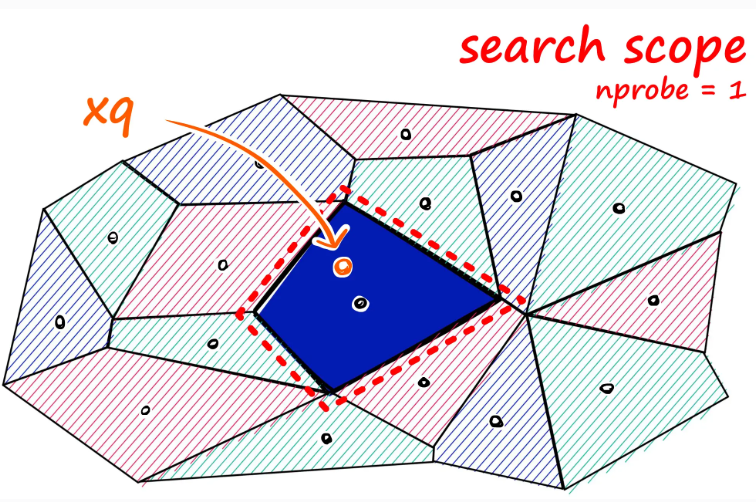

*Previously, the probe was done on single cell. If approximate search with IndexFlatL2 returns suboptimal results, we can improve accuracy by increasing \
the search scope. Let us increase the search scope by probing through 10 cells.*


In [156]:
index.nprobe = 10

In [157]:
%%time
D, I = index.search(xq, k)  # search
print(I)

[[ 330 6201 1305 7055]]
CPU times: user 2.51 ms, sys: 144 μs, total: 2.65 ms
Wall time: 1.98 ms


In [158]:
data['sentences'].iloc[[330, 6201, 1305, 7055]]

330     A group of football players is running in the ...
6201    A group of people playing football is running ...
1305            Two groups of people are playing football
7055    A person playing football is running past an o...
Name: sentences, dtype: object

Since we have increased the search scope to 10, we see a increase in time taken to search. \
But compared to the first approach, this is still faster.

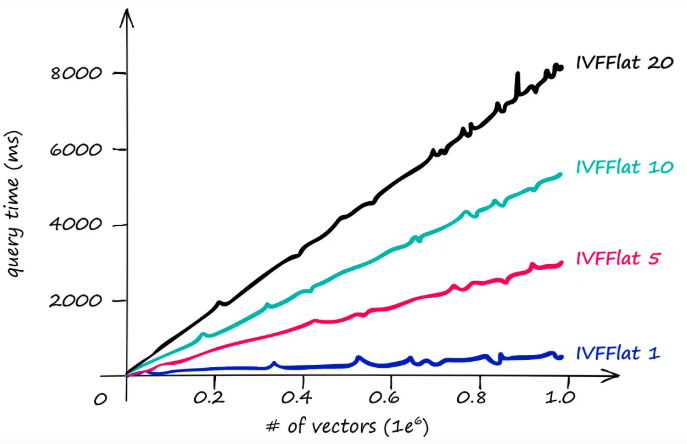

If we go ahead and attempt to use index.reconstruct(<vector_idx>) again, we will return a RuntimeError \
as there is no direct mapping between the original vectors and their index position, due to the addition of the IVF step.

In [159]:
index.make_direct_map()
index.reconstruct(7460)[:100]

array([ 3.2561803e-01, -4.0462384e-01, -1.1105952e+00, -1.3060088e-01,
        3.8851684e-01,  3.9714441e-01, -2.2666335e-01, -2.1231756e-01,
       -3.6297446e-01, -4.2624587e-01,  6.0993600e-01, -4.4442257e-01,
        5.7485890e-01,  8.9617747e-01, -5.7194018e-01, -4.1347891e-02,
       -8.9376137e-02, -7.9479331e-01,  4.3527469e-01,  1.8175033e-01,
       -2.7294454e-01, -4.6278486e-01,  9.9721730e-01, -3.2676503e-01,
       -5.3747118e-02,  5.5705465e-02,  4.4855246e-01, -7.8750029e-02,
        5.9549354e-02,  8.1098306e-01, -1.1720785e-01, -4.1840315e-01,
        1.3747996e-01, -3.5373816e-01,  5.1748049e-01, -3.9735578e-02,
        1.4243770e-01,  3.4129316e-01,  1.2909926e-01, -1.5620687e+00,
        1.5743145e-01, -8.2729566e-01,  3.7661992e-02,  1.5382151e-01,
       -9.0722847e-01, -1.0880311e+00, -9.3132555e-01,  1.4230413e+00,
        5.8060402e-01, -1.3445121e-01, -1.5603317e+00, -3.8744837e-01,
        2.0486400e+00,  2.5789204e-01, -1.0878117e+00, -7.5384378e-01,
      

### Quantization

Each index stores the vectors as full (eg. Flat) vectors, we can compress the vectors using \
product quantization.

PQ is an additional approximation step with a similar outcome to our use of IVF. \
Where IVF allowed us to approximate by reducing the scope of our search, \
PQ approximates the distance/similarity calculation instead.

PQ achieves this approximated similarity operation by compressing the vectors themselves, which consists of three steps.

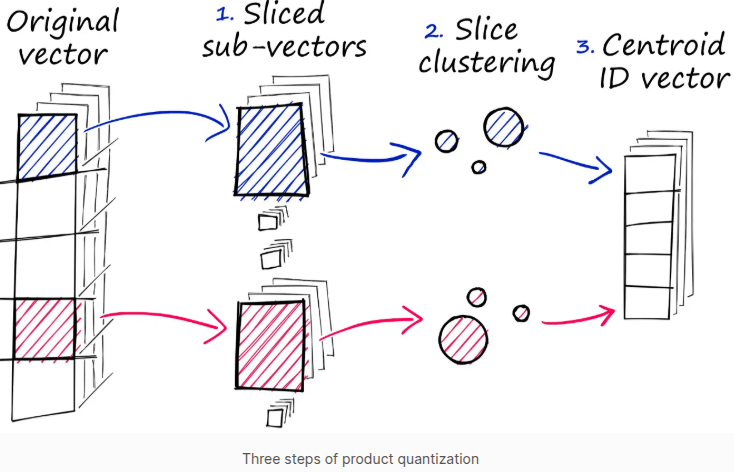

1. We split the original vector into several subvectors.
2. For each set of subvectors, we perform a clustering operation — creating multiple centroids for each sub-vector set.
3. In our vector of sub-vectors, we replace each sub-vector with the ID of it’s nearest set-specific centroid.

### Adding PQ to Indices

We need to train the index, and then add the embeddings

In [160]:
m = 8  # number of centroid IDs in final compressed vectors
bits = 8 # number of bits in each centroid

quantizer = faiss.IndexFlatL2(d)  # we keep the same L2 distance flat index
index = faiss.IndexIVFPQ(quantizer, d, nlist, m, bits) 

In [161]:
index.is_trained

False

In [162]:
index.train(sentence_embeddings)

In [163]:
index.add(sentence_embeddings)

In [168]:
index.nprobe = 5  # align to previous IndexIVFFlat nprobe value

In [169]:
%%time
D, I = index.search(xq, k)
print(I)

[[ 260  587 1305  330]]
CPU times: user 626 μs, sys: 324 μs, total: 950 μs
Wall time: 496 μs


In [170]:
[f'{i}: {sentences[i]}' for i in I[0]]

['260: A group of football players running down the field.',
 '587: Football players are on the field.',
 '1305: Two groups of people are playing football',
 '330: A group of football players is running in the field']

By adding PQ, we have reduced our time from milliseconds to microseconds. Minor \
changes in results are expected, thus both of our speed optimization operations, \
IVF and PQ, come at the cost of accuracy.


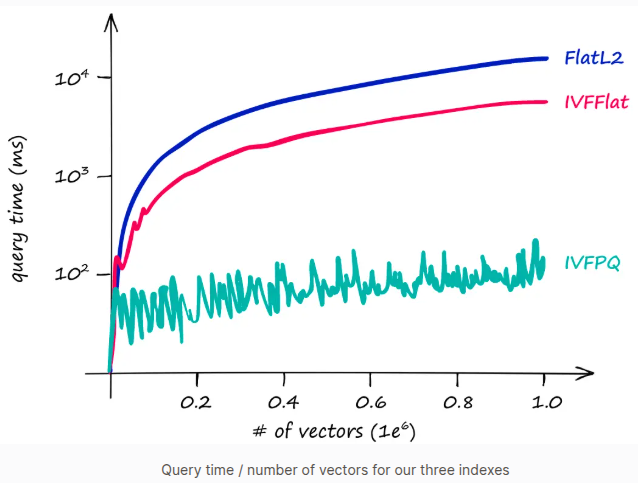

### Clearly, a lot can be done using IndexFlatL2, IndexIVFFlat, and IndexIVFPQ — and 
### each has many parameters that can be fine-tuned to our specific accuracy/speed requirements. 